In [2]:
import numpy as np
import pandas as pd
import os
from glob import glob
import pathlib
import shutil
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer
from tensorflow.keras import optimizers

In [3]:
train_dir = pathlib.Path("brain_tumor/training")
test_dir = pathlib.Path("brain_tumor/validation")
pred_dir = pathlib.Path("brain_tumor/test")

batch = 32
img_height = 224
img_width = 224
img_size = (img_height, img_width)

In [4]:
imagegenerator = image.ImageDataGenerator(rescale=1./255,
                                          rotation_range=30,
                                          width_shift_range=15,
                                          height_shift_range=15,
                                          brightness_range=[0.5, 1.5],
                                          horizontal_flip=True,
                                          vertical_flip=True)
imggen = image.ImageDataGenerator(rescale=1./255)

In [5]:
train_gen = imagegenerator.flow_from_directory(
    train_dir,
    batch_size=batch,
    target_size=img_size,
    seed=2021,
    color_mode='rgb',
    class_mode='binary'
)

test_gen = imggen.flow_from_directory(
    test_dir,
    batch_size=batch,
    target_size=img_size,
    color_mode='rgb',
    class_mode='binary'
)

pred_gen = imggen.flow_from_directory(
    pred_dir,
    batch_size=batch,
    target_size=img_size,
    color_mode='rgb',
    class_mode='binary',
    shuffle=False
)

Found 2300 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [6]:
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [29]:

# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
# x = something about image augmentation
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(100, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(50, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','mse'])
model.summary()

2021-11-30 23:30:29.940420: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-30 23:30:29.940707: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [30]:
from tensorflow.keras.callbacks import EarlyStopping
result = model.fit_generator(
    train_gen,
#     steps_per_epoch=50,
    epochs=20,
    validation_data=test_gen,
    validation_steps=10,
    callbacks=[EarlyStopping(patience=16, verbose=1)]
)
# fit
# import optimizer

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-11-30 23:30:30.900763: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/20
72/72 [==============================] - 45s 605ms/step - loss: 2.8606 - accuracy: 0.7333 - mse: 0.2378 - val_loss: 0.4094 - val_accuracy: 0.8813 - val_mse: 0.0971
Epoch 2/20
72/72 [==============================] - 44s 605ms/step - loss: 0.1775 - accuracy: 0.9441 - mse: 0.0438 - val_loss: 0.3145 - val_accuracy: 0.9281 - val_mse: 0.0604
Epoch 3/20
72/72 [==============================] - 43s 598ms/step - loss: 0.1130 - accuracy: 0.9605 - mse: 0.0302 - val_loss: 0.4464 - val_accuracy: 0.9125 - val_mse: 0.0731
Epoch 4/20
72/72 [==============================] - 43s 592ms/step - loss: 0.1151 - accuracy: 0.9537 - mse: 0.0340 - val_loss: 0.2536 - val_accuracy: 0.9375 - val_mse: 0.0498
Epoch 5/20
72/72 [==============================] - 43s 588ms/step - loss: 0.0838 - accuracy: 0.9751 - mse: 0.0198 - val_loss: 0.5909 - val_accuracy: 0.8969 - val_mse: 0.0844
Epoch 6/20
72/72 [==============================] - 43s 587ms/step - loss: 0.0811 - accuracy: 0.9720 - mse: 0.0221 - val_loss

In [7]:
model = tf.keras.models.load_model("with_mobilenet.h5")

2021-12-02 22:49:28.803296: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-02 22:49:28.803514: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
from tensorflow.keras.callbacks import EarlyStopping
result = model.fit(
    train_gen,
#     steps_per_epoch=100,
    epochs=100,
    validation_data=test_gen,
    callbacks=[EarlyStopping(patience=16, verbose=1)]
)

2021-12-02 22:49:31.723552: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/100
 2/72 [..............................] - ETA: 39s - loss: 9.6704e-04 - accuracy: 1.0000 - mse: 1.3192e-05

KeyboardInterrupt: 

In [9]:
predictions = model.predict(pred_gen, verbose=1)

7/7 [==============================] - 3s 390ms/step


In [38]:
model.save("with_mobilenet.h5")

200

In [41]:
np.set_printoptions(suppress=True)
predictions.round(0)

array([[0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],

In [10]:
from sklearn.metrics import accuracy_score, recall_score

In [11]:
print(accuracy_score(pred_gen.classes, predictions.round(0)))
print(recall_score(pred_gen.classes, predictions.round(0)))

0.975
0.98


In [101]:
model.layers

Text(93.77777777777786, 0.5, 'actual')

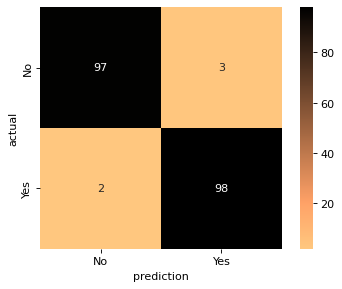

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(pred_gen.classes, predictions.round(0))
plt.figure(dpi=80)
sns.heatmap(conf_mat, cmap=plt.cm.copper_r , annot=True, square=True, fmt='d', 
       xticklabels=['No', 'Yes'],
       yticklabels=['No', 'Yes']);
plt.xlabel('prediction')
plt.ylabel('actual')

In [22]:
trueclass = pred_gen.classes

In [28]:
predclass = predictions.round(0).reshape(1,-1)

In [24]:
trueclass

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

In [36]:
predclass[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [38]:
j = 0
for i in predclass[0]:
    if i == 0:
        if j > 100:
            print(i, j) 
    j+=1

0.0 164
0.0 177


In [47]:
total_images = pred_gen.n

In [52]:
#iterations to cover all data, so if batch is 5, it will take total_images/5  iteration 

x , y = [] , []
for i in range(200):
    a , b = pred_gen.next()
    x.extend(a) 
    y.extend(b)

In [68]:
import cv2

y1463 = cv2.imread("brain_tumor/test/yes/y1463.jpg")
y1463 = cv2.resize(y1463, (224,224), interpolation=cv2.INTER_AREA)

y1476 = cv2.imread("brain_tumor/test/yes/y1476.jpg")
y1476 = cv2.resize(y1476, (224,224), interpolation=cv2.INTER_AREA)

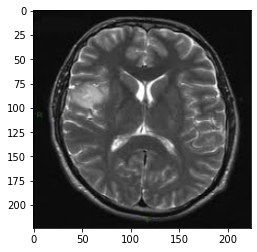

In [69]:
import matplotlib.pyplot as plt
plt.imshow(y1463)

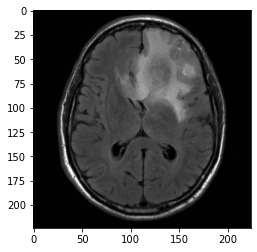

In [70]:
plt.imshow(y1476)

In [71]:
j = 0
for i in predclass[0]:
    if i == 1:
        if j < 100:
            print(i, j) 
    j+=1

1.0 18
1.0 19
1.0 59


In [ ]:
y1463 = cv2.imread("brain_tumor/test/yes/y1463.jpg")
y1463 = cv2.resize(y1463, (224,224), interpolation=cv2.INTER_AREA)

y1476 = cv2.imread("brain_tumor/test/yes/y1476.jpg")
y1476 = cv2.resize(y1476, (224,224), interpolation=cv2.INTER_AREA)

y1476 = cv2.imread("brain_tumor/test/yes/y1476.jpg")
y1476 = cv2.resize(y1476, (224,224), interpolation=cv2.INTER_AREA)

In [90]:
import visualkeras

In [96]:
visualkeras.layered_view(model, legend=True, scale_xy=40, background_fill = None).show()

In [97]:
visualkeras.layered_view(model, legend=True).show()